In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
from copy import deepcopy as copy

IMG_PATH = "_img"
CACHE_PATH = "../fitting/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

from itertools import combinations
import numpy as np
from scipy.stats import expon, chi2
from scipy.optimize import least_squares
import pandas as pd
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from astropy import units as u
from dust_extinction.parameter_averages import F99

from MaStarChecks.io import load_libraries
from MaStarChecks.preprocessing import build_train_test
from MaStarChecks.plotting.analysis import build_comparison_table, consistency_plot, delta_plot, delta_inset_plot
from MaStarChecks.plotting.styles import GSL_COLOR, Y19_COLOR, MASTAR_CMAP, MASTAR_COLOR, LIGHT_COLOR, MED_COLOR


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.2")

LABELS = ("GSL", "MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM", "EBV"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r"", r"mag"]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$", r"$E(B-V)$"], units.values())}

In [10]:
# TODO: use the spectral energy distributions in physical units to improve the logg estimation

spectra, catalogues = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, use_cache=True, cache_path=CACHE_PATH)

catalogue = []
for label, c in catalogues.items():
    c["LIBRARY"] = label
    catalogue.append(c)
catalogue = pd.concat(catalogue, axis="index", ignore_index=True)
catalogue.rename(columns=cols, inplace=True)

spectra = pd.concat([s["FLUX"] for label, s in spectra.items()], axis="index", ignore_index=True)

catalogue[cols.get("TEFF")] = np.log10(catalogue[cols.get("TEFF")])

# add random color excess to each star ---------------------------------------------------------------------------------------------------------------------------------------
n, xe = np.histogram(catalogue[cols.get("EBV")].dropna().values, bins=10)
x = (xe[1:]+xe[:-1])/2
n = n / n.max()
ebv_max = xe.max()

res = least_squares(lambda pars: chi2.pdf(x, df=pars[0], loc=pars[1], scale=pars[2]) - n, x0=(0, 0, 1), bounds=((0, 0, 0), (np.infty, np.infty, np.infty)), jac="3-point", method="trf")
# plt.plot(x, n, "ok")
# plt.plot(x, chi2.pdf(x, df=res.x[0], loc=res.x[1], scale=res.x[2]))
pdf = chi2(df=res.x[0], loc=res.x[1], scale=res.x[2])

RV = 3.1
ext = F99(Rv=RV)
gsl_mask = (catalogue.LIBRARY == "GSL").values
catalogue.loc[gsl_mask, cols.get("EBV")] = pdf.rvs(gsl_mask.sum())
for idx, ebv in catalogue.loc[gsl_mask, cols.get("EBV")].items():
    while ebv > ebv_max:
        ebv = pdf.rvs()
        catalogue.loc[idx, cols.get("EBV")] = ebv
for idx, spectrum in spectra.iterrows():
    spectra.loc[idx] = spectrum.values * ext.extinguish(spectrum.index.values.astype(float)*u.AA, Ebv=catalogue.loc[idx, cols.get("EBV")])
# add random color excess to each star ---------------------------------------------------------------------------------------------------------------------------------------

y = catalogue.filter(items=list(cols.values()))
# masking stars with weird alpha abundances
y = y.mask((catalogue.LIBRARY=="MaStar")&(y[cols.get("ALPHAM")]<=-0.1))

training_set, testing_set, labelled_set = build_train_test(labels=y, test_ratio=0.10, random_state=123, verbose=True)

X_train = spectra.loc[training_set]
y_train = y.loc[training_set]

X_test = spectra.loc[testing_set]
y_test = y.loc[testing_set]

X_labelled = spectra.loc[labelled_set]
y_labelled = y.loc[labelled_set]
y_labelled[cols.get("TEFF")] = 10**y_labelled[cols.get("TEFF")]

training_set_gsl = training_set[catalogue.loc[training_set].LIBRARY=="GSL"]
training_set_y19 = training_set[catalogue.loc[training_set].LIBRARY=="MaStar"]
testing_set_gsl = testing_set[catalogue.loc[testing_set].LIBRARY=="GSL"]
testing_set_y19 = testing_set[catalogue.loc[testing_set].LIBRARY=="MaStar"]

labelled set : 32796
training set : 29516
testing set  : 3280


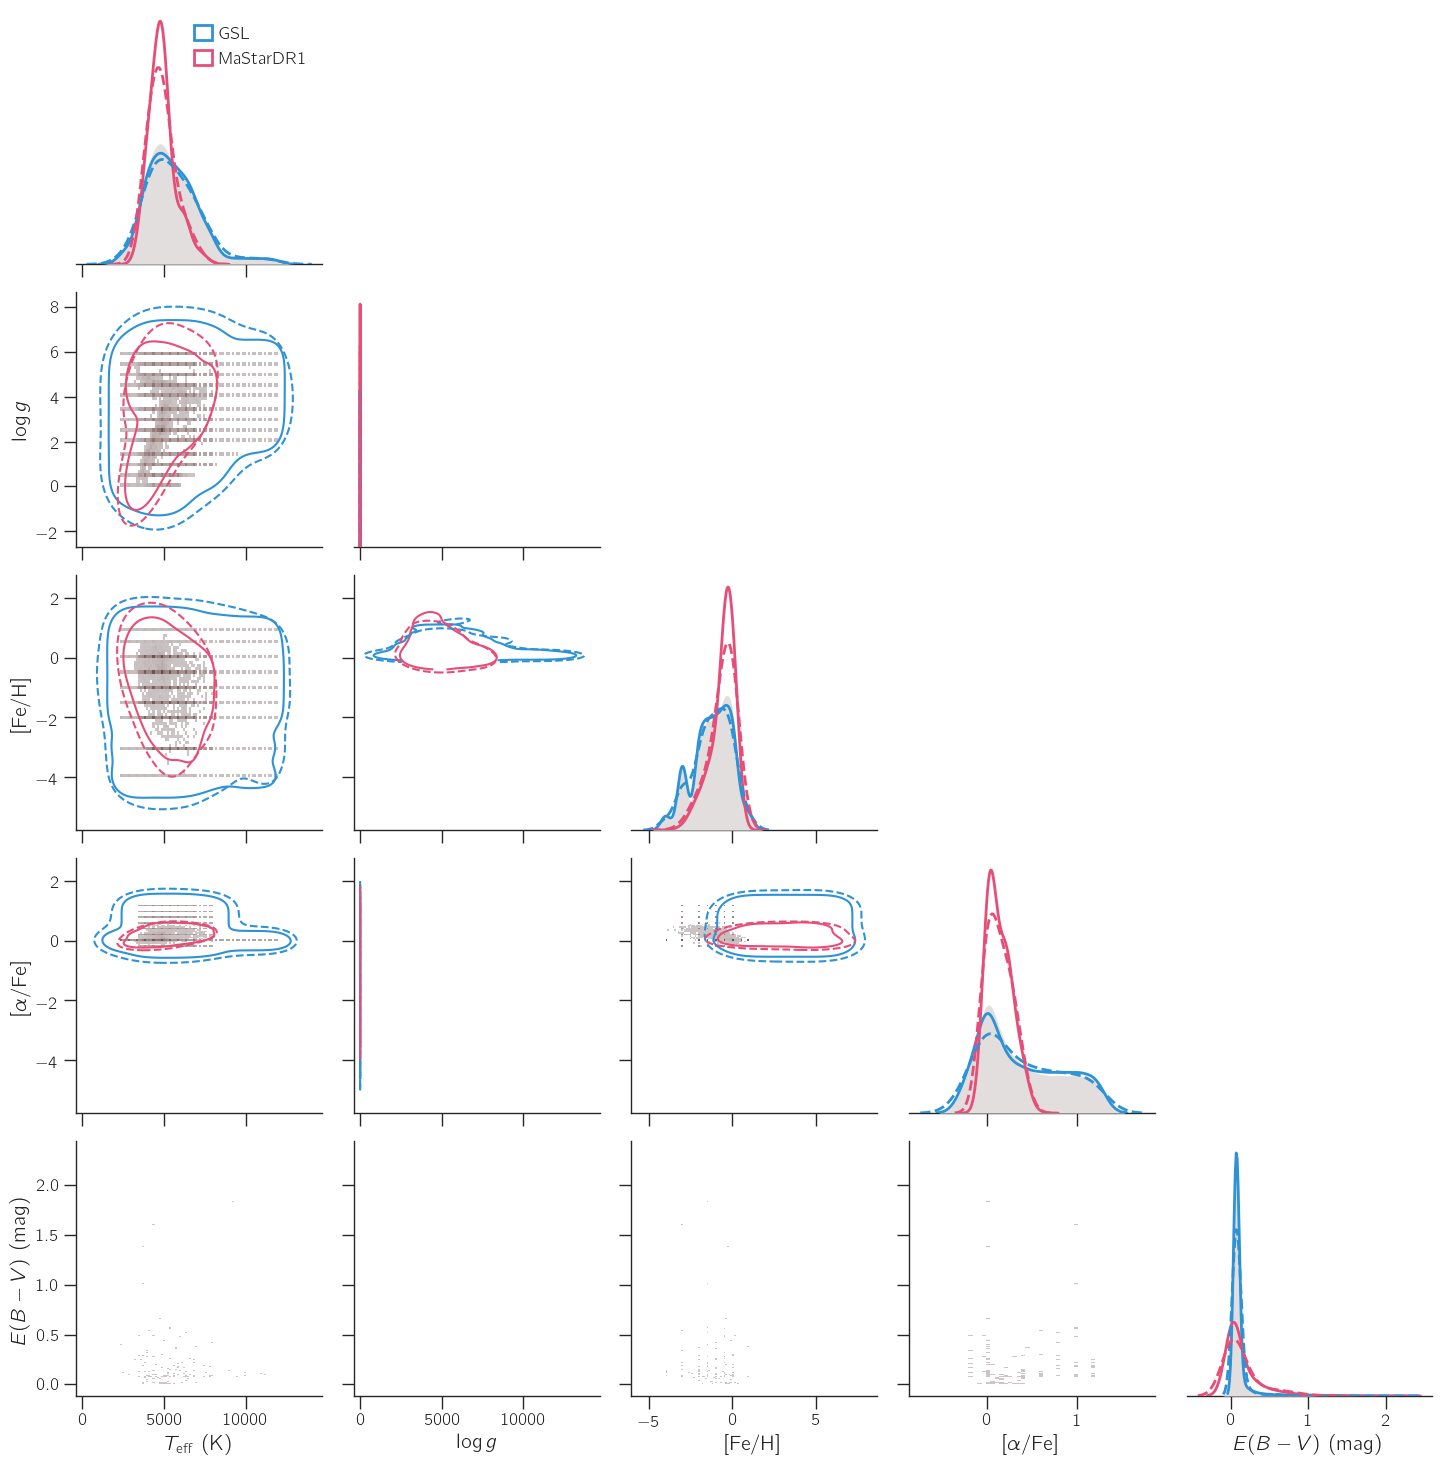

In [13]:
g = sns.pairplot(y_labelled, kind="hist", diag_kind="kde", corner=True, height=3,
                 plot_kws={"stat":"density", "color":LIGHT_COLOR, "alpha":1.0, "linewidth":0},
                 diag_kws={"shade":True, "bw_adjust":2, "lw":0, "color":LIGHT_COLOR, "alpha":1.0},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
for (i, column), ax in zip(enumerate(y.columns), g.diag_axes):
    
    sns.kdeplot(x=y_labelled.loc[training_set_gsl,column], bw_adjust=2, color=GSL_COLOR, lw=2, ax=ax)
    sns.kdeplot(x=y_labelled.loc[training_set_y19,column], bw_adjust=2, color=Y19_COLOR, lw=2, ax=ax)
    
    sns.kdeplot(x=y_labelled.loc[testing_set_gsl,column], bw_adjust=2, color=GSL_COLOR, lw=2, ls="--", ax=ax)
    sns.kdeplot(x=y_labelled.loc[testing_set_y19,column], bw_adjust=2, color=Y19_COLOR, lw=2, ls="--", ax=ax)
    
for (column_x,column_y), (j,i) in zip(combinations(y.columns, 2), (combinations([0,1,2,3], 2))):
    sns.kdeplot(x=y_labelled.loc[training_set_gsl,column_x],
                y=y_labelled.loc[training_set_gsl,column_y],
                bw_adjust=2, levels=(0.01,), color=GSL_COLOR, linewidths=1.5, ax=g.axes[i,j])
    sns.kdeplot(x=y_labelled.loc[training_set_y19,column_x],
                y=y_labelled.loc[training_set_y19,column_y],
                bw_adjust=2, levels=(0.01,), color=Y19_COLOR, linewidths=1.5, ax=g.axes[i,j])
    
    sns.kdeplot(x=y_labelled.loc[testing_set_gsl,column_x],
                y=y_labelled.loc[testing_set_gsl,column_y],
                bw_adjust=2, levels=(0.01,), color=GSL_COLOR, linewidths=1.5, linestyles="--", ax=g.axes[i,j])
    sns.kdeplot(x=y_labelled.loc[testing_set_y19,column_x],
                y=y_labelled.loc[testing_set_y19,column_y],
                bw_adjust=2, levels=(0.01,), color=Y19_COLOR, linewidths=1.5, linestyles="--", ax=g.axes[i,j])

handles = [mpatches.Patch(edgecolor=GSL_COLOR, facecolor="none", lw=2, label="GSL"),
           mpatches.Patch(edgecolor=Y19_COLOR, facecolor="none", lw=2, label="MaStarDR1")]
legend = g.axes[0,0].legend(handles=handles, loc=1)

# g.axes[1,0].set_xscale("log")
# g.axes[1,0].set_xlim(xlim[::-1])
# # g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(3))
# # g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(2))
# g.axes[1,0].set_ylim(ylim[::-1])
# g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])

# g.fig.savefig("../analysis/_img/training-testing-sets.png", bbox_inches="tight")
plt.show()

In [14]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pickle


pickle_filename = "_cache/estimator-mor-v3.1.2-cleaned-v2-gsl-dust.pk"

if not os.path.isfile(pickle_filename):
    mor = {}
    mor["mode"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="ls",
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)
    
    mor["P16"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="quantile",
        alpha=0.16,
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)
    
    mor["P50"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="quantile",
        alpha=0.50,
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)
    
    mor["P84"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="quantile",
        alpha=0.84,
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)

    pickle.dump(mor, open(pickle_filename, "wb"))
else:
    mor = pickle.load(open(pickle_filename, "rb"))

      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
         1           2.4460          140.24m
         1           0.1695          140.01m
         1           0.0125          148.61m
         1           1.0925          149.43m
         1           0.0194          155.62m
         2           2.1540          139.70m
         2           0.1530          139.68m
         2           0.0103          147.19m
         2           0.9589          147.80m
         2           0.0157          154.09m
         3           1.8997          138.58m
         3           0.1400          139.27m
         3           0.0084          145.31m
         3           0.8492          146.10m
         3           0.0127          152.11m
         4           1.6865          137.17m
         4           0.1284          137.91m
     

In [15]:
y_model = pd.DataFrame(index=y.index, columns=y.columns, data=mor["mode"].predict(spectra))
y[cols.get("TEFF")] = 10**y[cols.get("TEFF")]
y_model[cols.get("TEFF")] = 10**y_model[cols.get("TEFF")]
y_model

$T_\mathrm{eff}$~(K)  $\log{g}$  $[\mathrm{Fe}/\mathrm{H}]$  \
0               2336.294762   0.598679                    0.173482   
1               2313.526866   0.711456                    0.580869   
2               2356.257724   0.328485                   -0.099375   
3               2335.098353   0.407348                   -0.415893   
4               2331.034650   0.147598                   -0.925517   
...                     ...        ...                         ...   
50583           4941.274564   4.465332                   -0.231831   
50584           4725.350711   2.329681                   -1.309957   
50585           9446.434610   4.447986                   -0.543730   
50586           4491.993660   3.493890                   -0.001880   
50587           6426.957561   4.248210                   -0.648489   

       $[\alpha/\mathrm{Fe}]$  $E(B-V)$~(mag)  
0                   -0.029967        0.072647  
1                   -0.052694        0.072583  
2                    0.036517        0.073691  
3                    0.011266        0.076791  
4                    0.002627        0.070439  
...                       ...             ...  
50583                0.130179        0.007507  
50584                0.239816        0.017689  
50585                0.130166        0.411251  
50586                0.112069        0.011374  
50587                0.213932        0.038800  

[50588 rows x 5 columns]

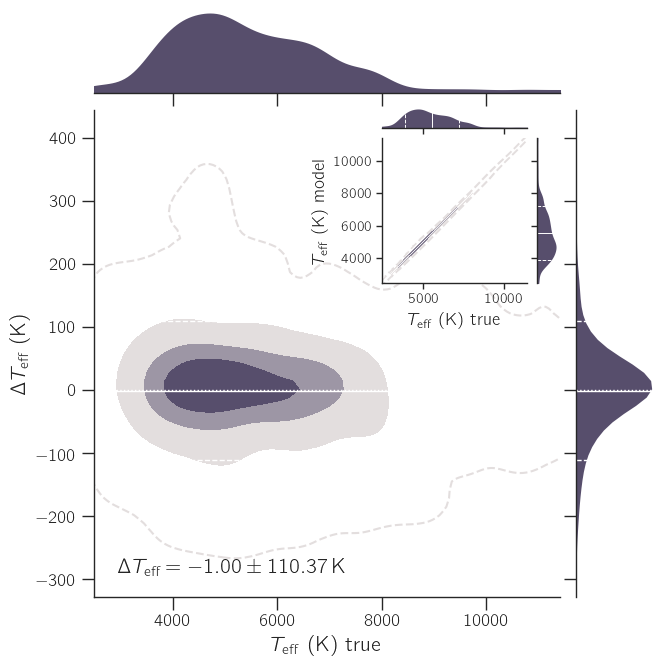

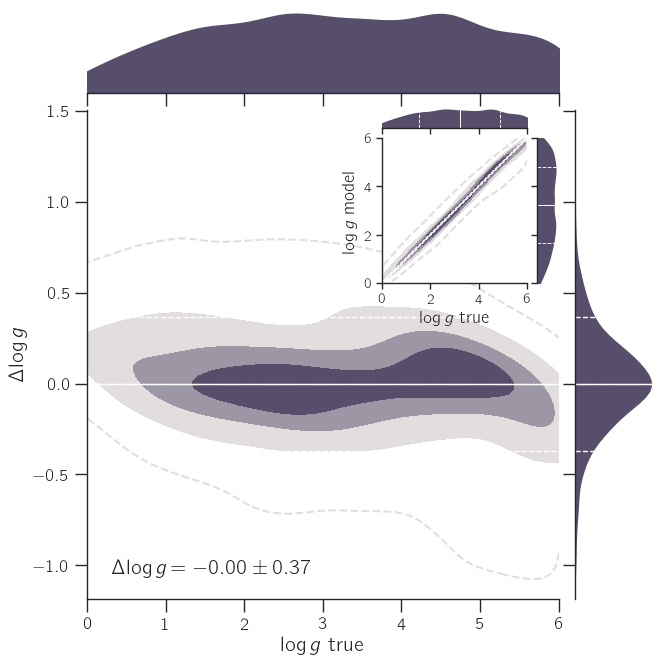

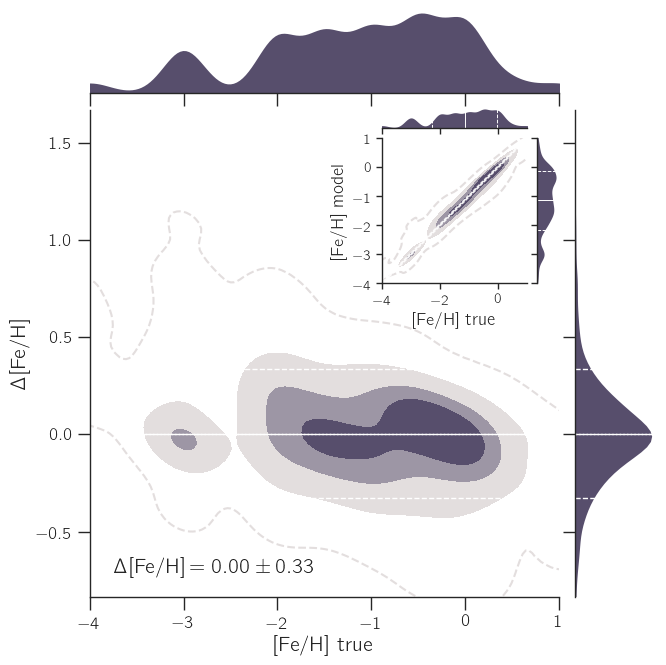

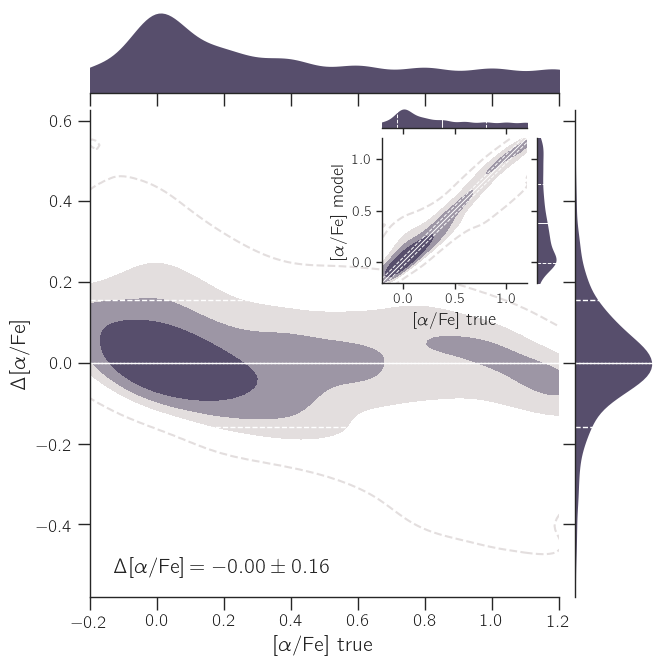

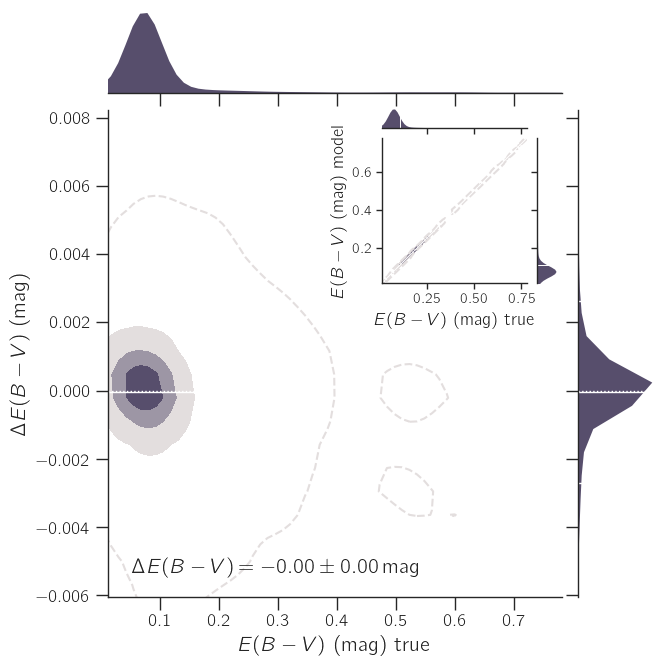

In [16]:
compare_with = "true"
comparison = build_comparison_table(y_model.loc[testing_set], y.loc[testing_set], labela="model", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\Delta$")

for label, column in cols.items():
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="model", delta_prefix=r"$\Delta$"
        )
#     d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")
plt.show()

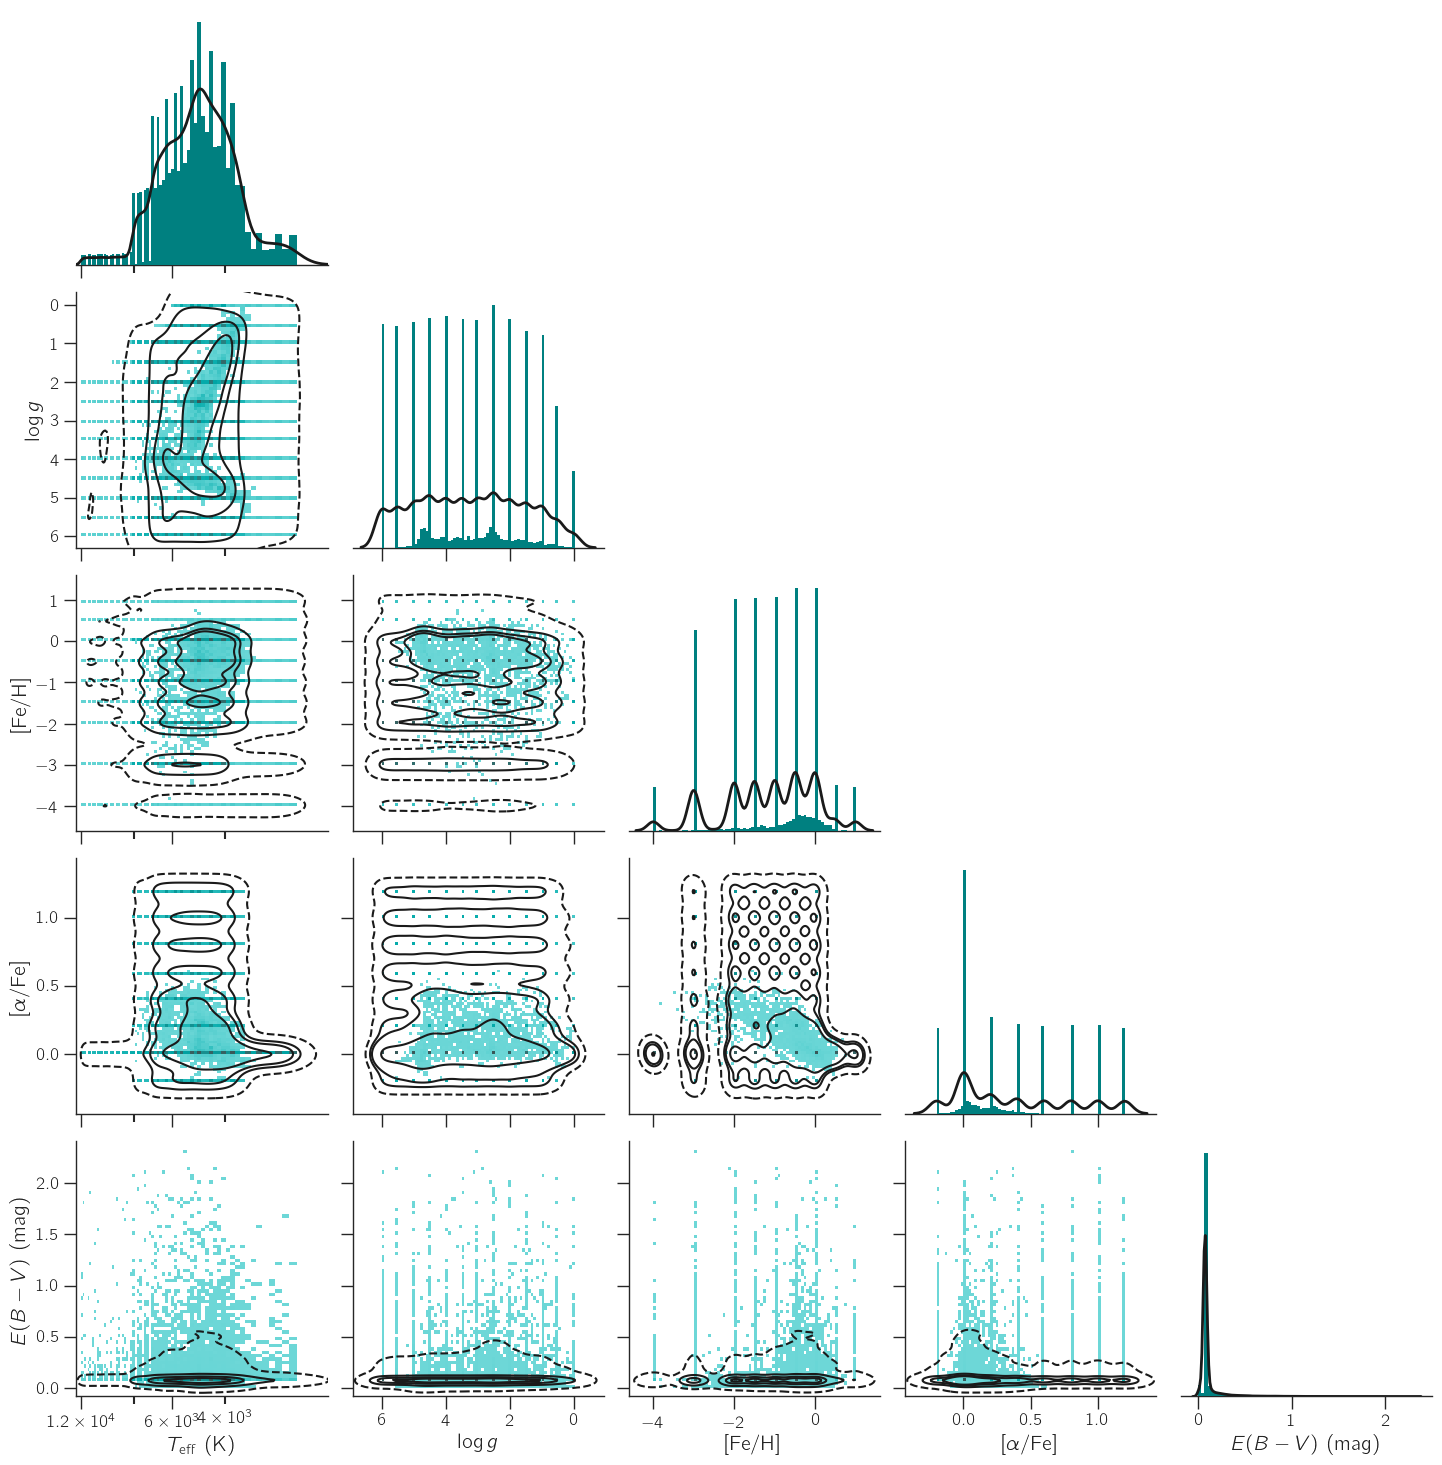

In [17]:
g = sns.pairplot(y.loc[training_set], kind="hist", corner=True, height=3,
                 plot_kws={"color":"teal", "bins":70, "stat":"density"},
                 diag_kws={"lw":0, "fc":"teal", "bins":70, "stat":"density"},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.map_diag(sns.kdeplot, lw=2, color="k")
g.map_lower(sns.kdeplot,
            levels=(0.05,0.25,0.50,0.75,1.00), color="k", linewidths=1.5, linestyles=("--","-","-","-","-"))

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(1))
g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])
plt.show()

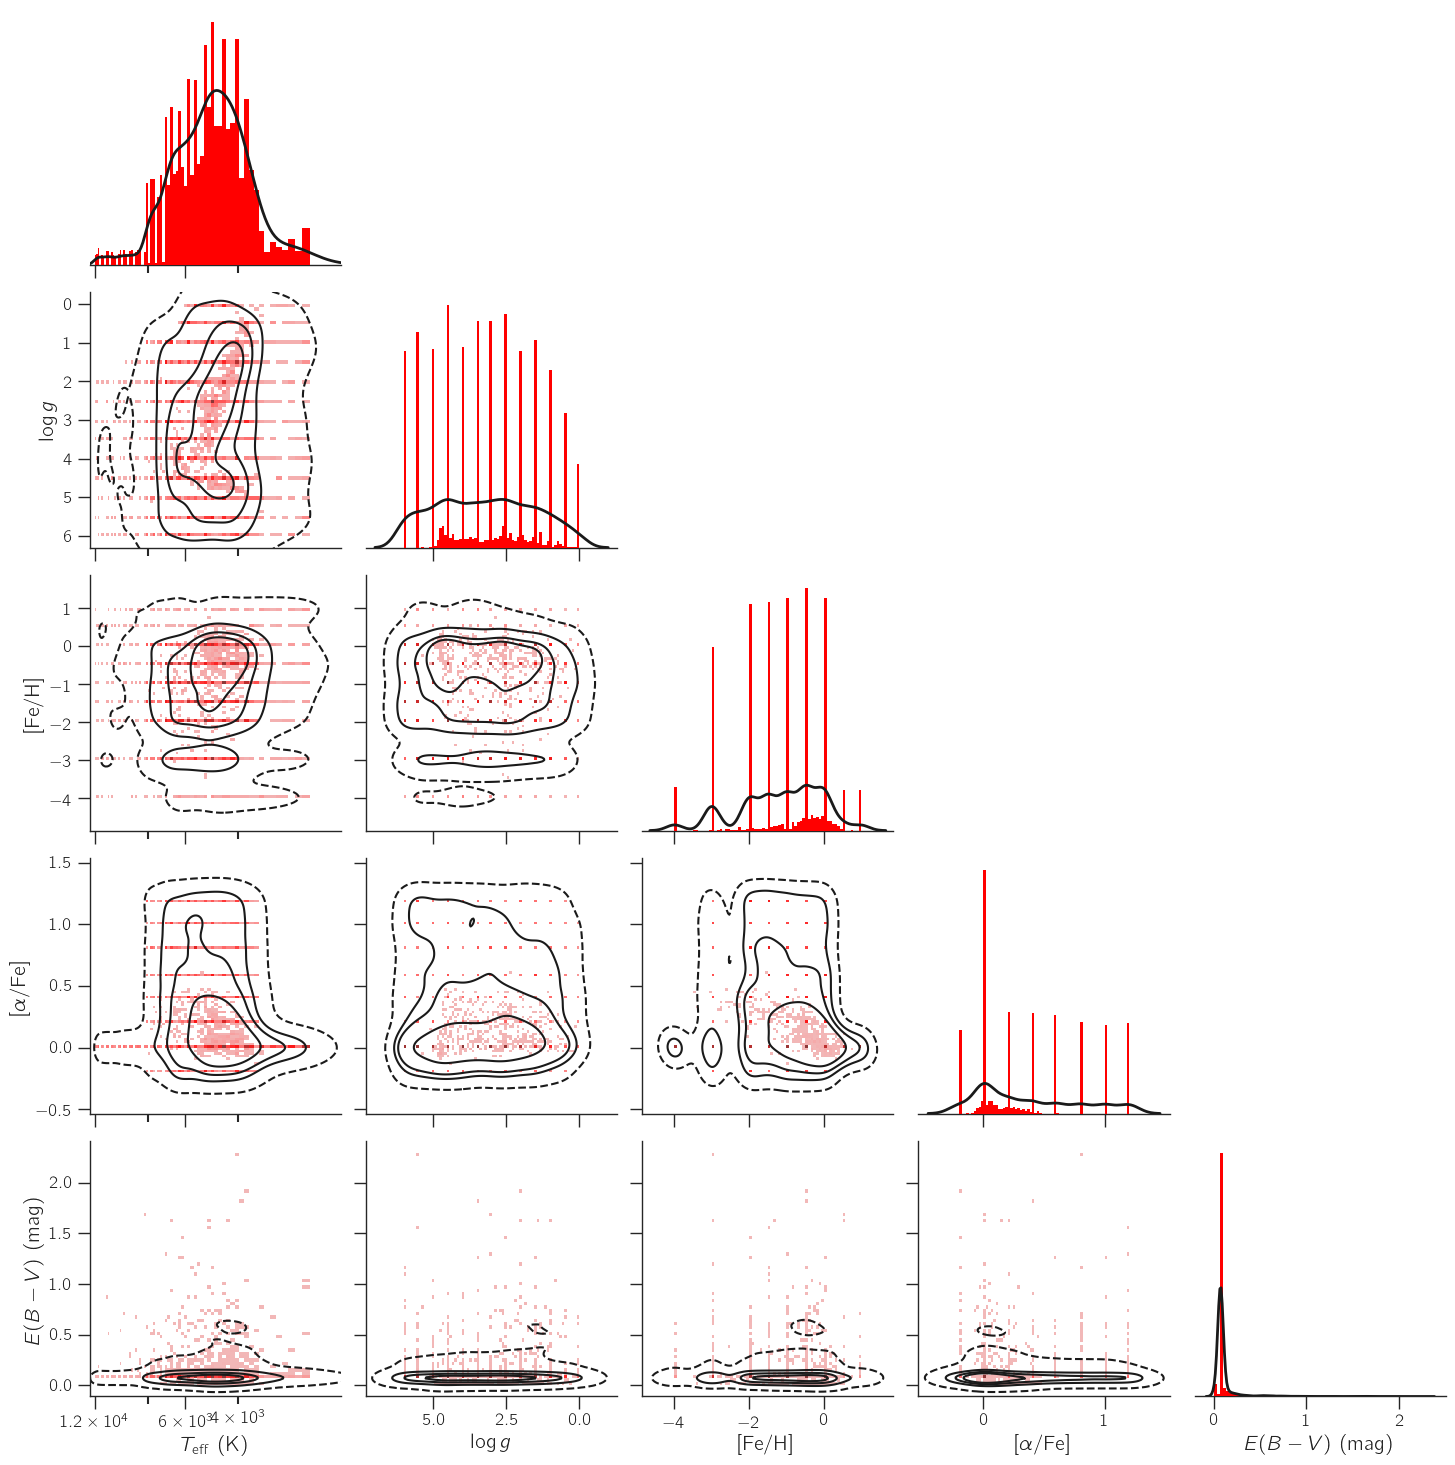

In [18]:
g = sns.pairplot(y.loc[testing_set], kind="hist", corner=True, height=3,
                 plot_kws={"color":"red", "bins":70, "stat":"density"},
                 diag_kws={"lw":0, "fc":"red", "bins":70, "stat":"density"},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.map_diag(sns.kdeplot, lw=2, color="k")
g.map_lower(sns.kdeplot,
            levels=(0.05,0.25,0.50,0.75,1.00), color="k", linewidths=1.5, linestyles=("--","-","-","-","-"))

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(1))
g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])
plt.show()

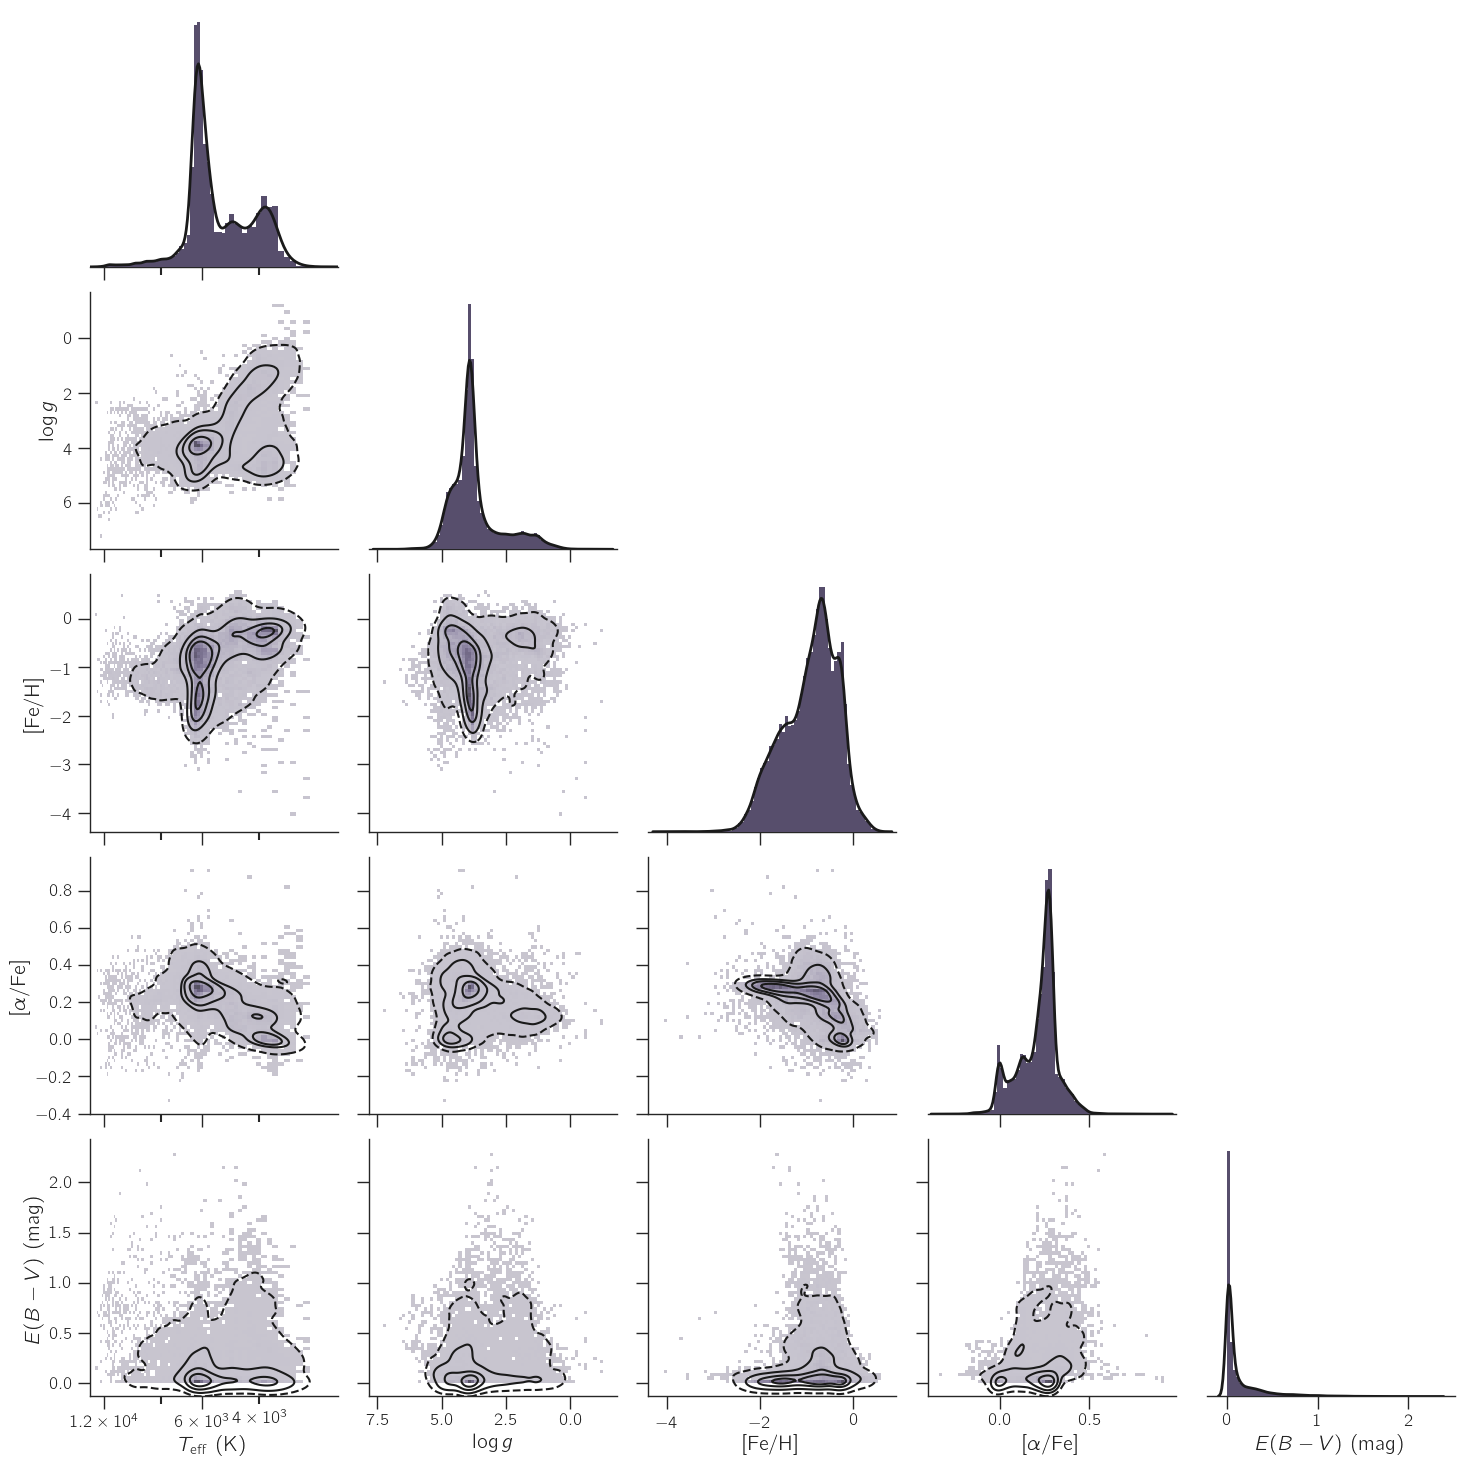

In [19]:
g = sns.pairplot(y_model.loc[catalogue.LIBRARY=="MaStar"], kind="hist", corner=True, height=3,
                 plot_kws={"color":MASTAR_COLOR, "bins":70, "stat":"density"},
                 diag_kws={"lw":0, "fc":MASTAR_COLOR, "bins":70, "stat":"density"},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.map_diag(sns.kdeplot, lw=2, color="k")
g.map_lower(sns.kdeplot,
            levels=(0.05,0.25,0.50,0.75,1.00), color="k", linewidths=1.5, linestyles=("--","-","-","-","-"))

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(1))
g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])
plt.show()

In [11]:
import shutil
from astropy.io import fits
from MaStarChecks.constants import BAR_FORMAT


mastar_idx = catalogue.index[catalogue.LIBRARY=="MaStar"]
X_mastar = spectra.loc[mastar_idx]
y_mastar = pd.DataFrame(index=catalogue.loc[mastar_idx, "ID"], columns=Y_COLUMNS, data=mor["mode"].predict(X_mastar))
y_mastar.TEFF = 10**y_mastar.TEFF

sed_list = sorted([f"processed-mastar-{ID}-{rec}.fits.gz" for ID, rec in zip(catalogue.ID.loc[X_mastar.index],catalogue.RECORD.loc[X_mastar.index].astype(int))])

CLASSIFIED_PATH = "../fitting/_data/classified-mastar-v3.1.2-cleaned-v2-gsl"
if not os.path.isdir(CLASSIFIED_PATH):
    os.mkdir(CLASSIFIED_PATH)

    for filename in tqdm(sed_list, desc="updating parameters", unit="star", ascii=True, bar_format=BAR_FORMAT):
        filename_src = os.path.join(PROCESSED_PATH, filename)
        filename_dst = os.path.join(CLASSIFIED_PATH, filename.replace("processed","classified-gsl"))
        if not os.path.isfile(filename_dst): shutil.copyfile(filename_src, filename_dst)

        with fits.open(filename_dst, "update") as sed_fits:
            for column in Y_COLUMNS:
                sed_fits[0].header[column] = y_mastar.loc[sed_fits[0].header["ID"], column]

In [12]:
import tarfile


def chunks(l, n):
    """Taken from https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks"""
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

COMPRESSED_PATH = "../_data/mastar-v3.1.2-classified-cleaned-v2-gsl"
if not os.path.isdir(COMPRESSED_PATH):
    os.mkdir(COMPRESSED_PATH)

    sed_list = sorted([os.path.join(CLASSIFIED_PATH, filename) for filename in os.listdir(CLASSIFIED_PATH) if filename.startswith("classified-gsl") and filename.endswith(".fits.gz") and "mastar" in filename])
    sed_chunks = list(enumerate(chunks(sed_list, 1000)))
    for i, chunk in tqdm(sed_chunks, desc="compressing chunks", unit="chunk", ascii=True, bar_format=BAR_FORMAT):
        compressed_filename = os.path.join(COMPRESSED_PATH, "mastar-seds-chunk-{:03d}.tar.bz2".format(i))
        if os.path.isfile(compressed_filename): continue
        with tarfile.open(compressed_filename, "w:bz2") as tar:
            for file in chunk:
                tar.add(file)